# Electric Vehicles Registered in Washington State
**An EDA Project With Geospatial Data**

# 1. Introduction

This notebook is about electric vehicles (EV) registered in the US state of Washington. Our aim is to see where these vehicles are now. 

We expect the majority of the EV to still be in the state of Washington. Tabulation and mapping will be used to bring out and show the findings.

# 2. Tools loading and dataset first look

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
import seaborn as sns
import plotly.express as px
from pandas.plotting import scatter_matrix

import math
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import warnings
warnings.simplefilter('ignore')
elec_type_colors = ['green', 'gold']

In [2]:
df_full = pd.read_csv('Electric_Vehicle_Population_Data.csv', index_col='DOL Vehicle ID')
df_full.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,Vehicle Location,Electric Utility,2020 Census Tract
DOL Vehicle ID,,,,,,,,,,,,,,,,
240684006,JTMAB3FV3P,Kitsap,Seabeck,WA,98380.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0,35.0,POINT (-122.8728334 47.5798304),PUGET SOUND ENERGY INC,5.303509e+10
474183811,1N4AZ1CP6J,Kitsap,Bremerton,WA,98312.0,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151.0,0.0,35.0,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,5.303508e+10
113120017,5YJ3E1EA4L,King,Seattle,WA,98101.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266.0,0.0,43.0,POINT (-122.3340795 47.6099315),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
108188713,1N4AZ0CP8E,King,Seattle,WA,98125.0,2014,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,46.0,POINT (-122.304356 47.715668),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
176448940,1G1FX6S00H,Thurston,Yelm,WA,98597.0,2017,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238.0,0.0,20.0,POINT (-122.5715761 46.9095798),PUGET SOUND ENERGY INC,5.306701e+10


In [3]:
print(f"The dataset shows that there have been {df_full.shape[0]} EV registered in the state of Washigton in the period covered.\nThe car model years span a period from {df_full['Model Year'].min()} to {df_full['Model Year'].max()}")

The dataset shows that there have been 205439 EV registered in the state of Washigton in the period covered.
The car model years span a period from 1997 to 2025


# 3. Cleaning and Inspection

## 3.1 Data cleaning


We will use short descriptive for both Electric Type and Clean Alternative Fuel Vehicle (CAFV) Eligibility.

    'Eligibility unknown as battery range has not been researched': 'not_verified_yet',
    'Clean Alternative Fuel Vehicle Eligible' : 'eligible',
    'Not eligible due to low battery range' : 'not eligible


In [4]:
df_full.isna().sum().to_frame('number of NaN').style.bar(cmap='Reds')

,number of NaN
VIN (1-10),0
County,3
City,3
State,0
Postal Code,3
Model Year,0
Make,0
Model,1
Electric Vehicle Type,0
Clean Alternative Fuel Vehicle (CAFV) Eligibility,0


In [5]:
df_full['Legislative District'] = df_full['Legislative District'].map(lambda x: str(x).split('.')[0])

In [6]:
df_full['Vehicle Location'] = df_full['Vehicle Location'].fillna(method='ffill')

The majority of the missing information, 442, is on Legislative District. This column will not be needed in this project. However, the missing values can be filled as shown below.

In [7]:
# Rename the values for Electric Vehicle Type
df_full['Electric Vehicle Type'] = df_full.iloc[:, 8].map(lambda x: 'PHEV' if 'PHEV' in x else 'BEV')

# Rename the values for Clean Alternative Fuel Vehicle (CAFV) Eligibility
CAFV_dico = {
    'Eligibility unknown as battery range has not been researched': 'not_verified_yet',
    'Clean Alternative Fuel Vehicle Eligible' : 'eligible',
    'Not eligible due to low battery range' : 'not eligible'   
}

df_full['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = df_full['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].map(CAFV_dico)

## 3.2 Descriptive summary

In [8]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205439 entries, 240684006 to 228335040
Data columns (total 16 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         205439 non-null  object 
 1   County                                             205436 non-null  object 
 2   City                                               205436 non-null  object 
 3   State                                              205439 non-null  object 
 4   Postal Code                                        205436 non-null  float64
 5   Model Year                                         205439 non-null  int64  
 6   Make                                               205439 non-null  object 
 7   Model                                              205438 non-null  object 
 8   Electric Vehicle Type                              205439 non-null  

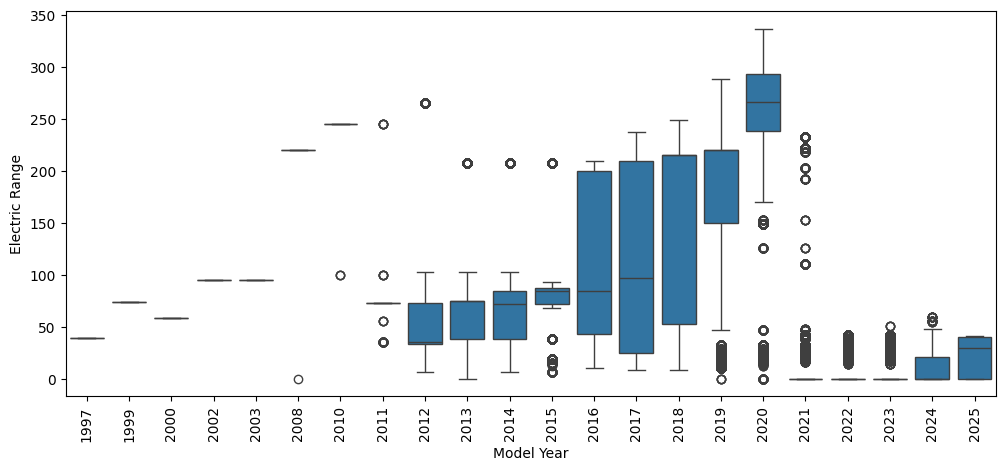

In [9]:

plt.figure(figsize=(12, 5))
sns.boxplot(df_full, y='Electric Range', x='Model Year')
plt.xticks(rotation=90)
plt.show()

The observations here are quite surprising.
* The electric range of the cars kept increasing over the years and topped in 2020. It started decreasing, which does not align with technology and innovation -> but maybe attributable to COVID lockdown. 

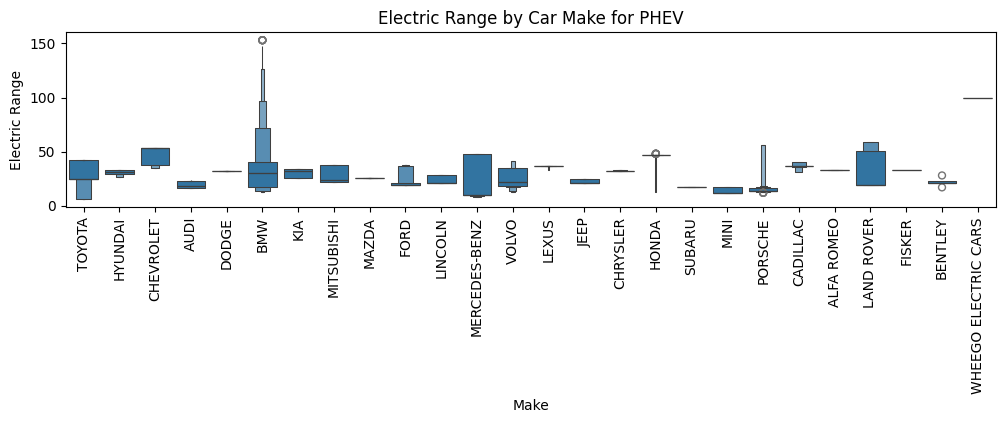

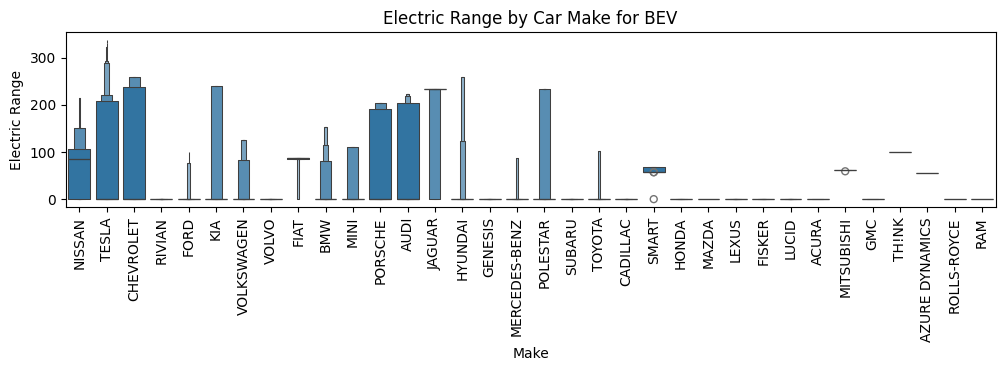

In [10]:
for e, EV_Type in enumerate(['PHEV', 'BEV'], start=1):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, e)
    sns.boxenplot(df_full[df_full['Electric Vehicle Type']==EV_Type], y='Electric Range', x='Make')
    plt.xticks(rotation=90)
    plt.title(f'Electric Range by Car Make for {EV_Type}')
    plt.show()

In [11]:
df_full.describe(exclude='number').T

,count,unique,top,freq
VIN (1-10),205439,12140,7SAYGDEE6P,1221
County,205436,205,King,105237
City,205436,770,Seattle,33328
State,205439,45,WA,204997
Make,205439,42,TESLA,90318
Model,205438,152,MODEL Y,43437
Electric Vehicle Type,205439,2,BEV,161539
Clean Alternative Fuel Vehicle (CAFV) Eligibility,205439,3,not_verified_yet,114172
Legislative District,205439,50,41,12994
Vehicle Location,205439,928,POINT (-122.1207376 47.6705374),5204


## What comes out of the data description

### Geographical 
* There are 45 US states in the report,
* There are 205 counties,
* There are 770 cities,
* Only 74 electric utilities. Which is less than one for every ten cities on average.

### Makes and Models
* There are 42 makes,
* There are 152 models.


# 4. EDA of all the EVs


## 4.1 Counting

In [12]:
count_EV_types = df_full['Electric Vehicle Type'].value_counts()

count_EV_types.to_frame(name='Vehicle by EV Type').style.bar(cmap='Greens')

,Vehicle by EV Type
Electric Vehicle Type,
BEV,161539
PHEV,43900


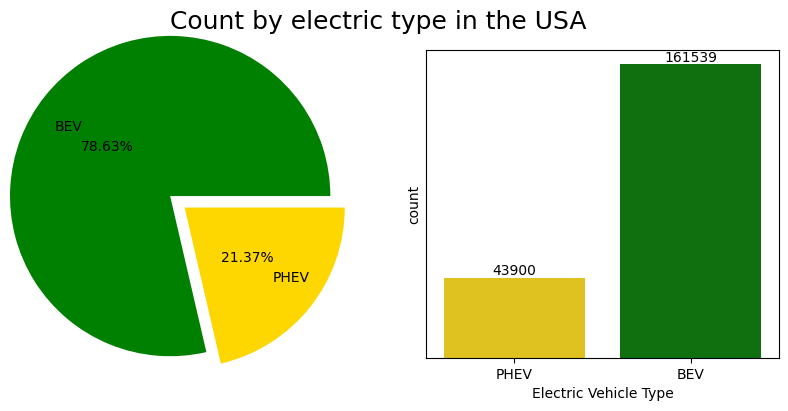

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
count_EV_types.plot.pie(autopct='%.2f%%', radius=1.3,
                        explode=[0.1, 0.05],colors=elec_type_colors,
                        pctdistance=0.5, labeldistance=0.7)
plt.ylabel('')
plt.subplot(1,2,2)
ax = sns.countplot(df_full, x='Electric Vehicle Type', palette=['gold', 'green'])
for count in ax.containers:
    ax.bar_label(count)
plt.yticks([])
plt.suptitle('Count by electric type in the USA', fontsize=18)
plt.show()

Battery Electric Vehicles(BEV) are more popular than Plug_in Hybrid Electric Vehicles(PHEV). In subsequent steps they will be refered to as: BEV and PHEV.

In [14]:
df_full['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts(normalize=True).to_frame()

cafv_s = df_full['Clean Alternative Fuel Vehicle (CAFV) Eligibility']
cafv_counts = cafv_s.value_counts().to_frame()#.style.bar(cmap='Greens')
cafv_counts['%tage'] = cafv_s.value_counts(normalize=True)*100
cafv_counts.style.background_gradient(cmap='Greens', axis=0)

cafv_counts

,count,%tage
Clean Alternative Fuel Vehicle (CAFV) Eligibility,,
not_verified_yet,114172,55.574647
eligible,70016,34.081163
not eligible,21251,10.344190


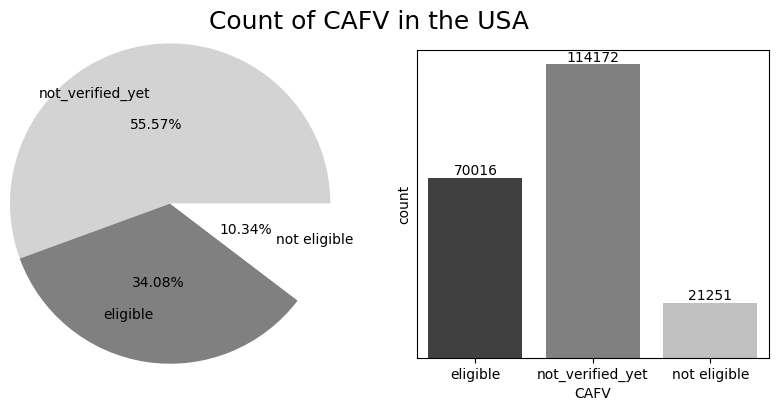

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
cafv_counts['count'].plot.pie(autopct='%.2f%%', radius=1.3,
                        colors=['lightgrey', 'grey', 'white'],
                        pctdistance=0.5, labeldistance=0.7)
plt.ylabel('')
plt.subplot(1,2,2)
ax = sns.countplot(df_full, x='Clean Alternative Fuel Vehicle (CAFV) Eligibility', palette='gray')
for count in ax.containers:
    ax.bar_label(count)
plt.yticks([])
plt.xlabel('CAFV')
plt.suptitle('Count of CAFV in the USA', fontsize=18)
plt.show()

34 % of the vehicles are eligible for alternative fuel, while 10 % are not.

## 4.2 Mapping

In [16]:
world_filepath = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_filepath)
USA = world.loc[world["ISO_A3"]=='USA']

In [17]:
# Convert the WKT strings to geometry
gdf_full = df_full.copy()
gdf_full['Vehicle Location'] = gdf_full['Vehicle Location'].apply(lambda x: str(x)).apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
gdf_full = gpd.GeoDataFrame(gdf_full, geometry='Vehicle Location', crs='EPSG:32630')

In [18]:
red_square = Polygon([(-115.5,  50), (-115.5, 44), (-126, 44), (-126, 50)])
poly_gdf = gpd.GeoDataFrame(geometry=[red_square], crs=world.crs)

In [19]:
gdf_full['lon'] = gdf_full['Vehicle Location'].apply(lambda p: p.x)
gdf_full['lat'] = gdf_full['Vehicle Location'].apply(lambda p: p.y)

gdf_full[['lon', 'lat']].head()

,lon,lat
DOL Vehicle ID,,
240684006,-122.872833,47.579830
474183811,-122.696120,47.575958
113120017,-122.334080,47.609932
108188713,-122.304356,47.715668
176448940,-122.571576,46.909580


In [ ]:
# Create the map
map_usa = folium.Map(location=[39.5, -99.7], tiles='cartodbpositron', zoom_start=4.4)

# Add points to the map
mc = MarkerCluster()
for idx, row in gdf_full.iterrows():
    if not math.isnan(row['lon']) and not math.isnan(row['lat']):
        mc.add_child(Marker([row['lat'], row['lon']]))
map_usa.add_child(mc)

# Display the map
map_usa

In [ ]:
# Create the map
map_usa = folium.Map(location=[39.5, -99.7], tiles='cartodbpositron', zoom_start=4.4)

# Set of EVs that left the state of WA
gdf_left = gdf_full[gdf_full['State']!='WA']

def color_scheem(val):
    if val == 'BEV':
        return 'green'
    else:
        return 'yellow'

for i in range(0, len(gdf_left)):
    folium.Circle(
        location= (gdf_left.iloc[i]['lat'], gdf_left.iloc[i]['lon']),
        radius=4000,
        color=color_scheem(gdf_left.iloc[i]['Electric Vehicle Type'])
    ).add_to(map_usa)

# Diplay th map
map_usa

### How many EVs left the state of Washington

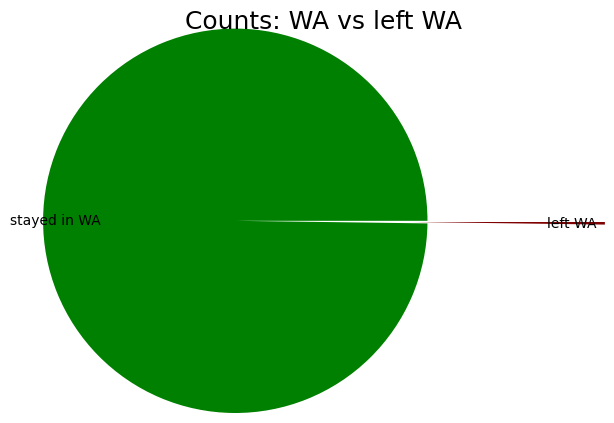

In [22]:
df_full['WA_vs_Other'] = df_full['State'].apply(lambda x: 'stayed in WA' if x=='WA' else 'left WA')

df_full['WA_vs_Other'].value_counts().plot.pie(radius=1.3,explode=[0.6, 0.6], colors=['green', 'maroon'], pctdistance=0.5, labeldistance=0.7)
plt.axis('off')
plt.title('Counts: WA vs left WA', fontsize=18)
plt.show()

In [23]:
# Set of the cars that left the state
df_left = df_full[df_full['State']!='WA']
print('{} EVs left the state of Washington to other states. This is just about {:.3f} % of the EVs registered there.'.format(df_left.shape[0], 100*df_left.shape[0]/df_full.shape[0]))

442 EVs left the state of Washington to other states. This is just about 0.215 % of the EVs registered there.


### How many for each state

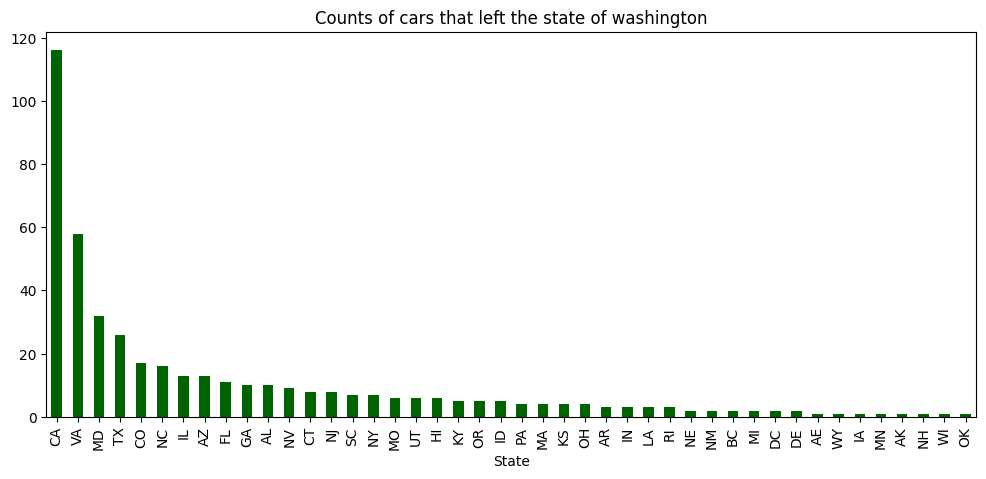

In [24]:
df_left['State'].value_counts().plot.bar(figsize=(12,5), color='darkgreen', 
                                         title='Counts of cars that left the state of washington')
plt.show()

California, despite having less than 120 cars, is the state that received most of the cars that left the state of registration.  

In [25]:
df_left['State'].value_counts(normalize=True).to_frame().head(10).style.background_gradient(cmap='YlGn')

,proportion
State,
CA,0.262443
VA,0.131222
MD,0.072398
TX,0.058824
CO,0.038462
NC,0.036199
IL,0.029412
AZ,0.029412
FL,0.024887


### 26.24 % of those EVs wen to California, 13.12 % to Virginia

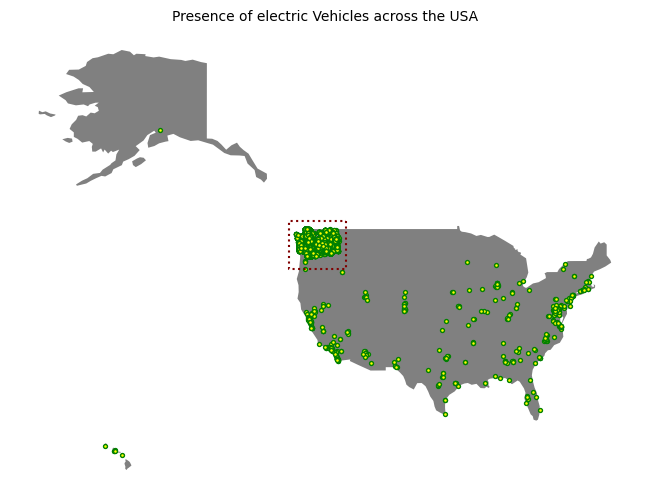

The area in the red box account for more than 99% of the electric cars in this dataset


In [26]:
ax_1 = USA.plot(figsize=(18, 6), color='grey')
gdf_full['Vehicle Location'].plot(color='yellow', ax=ax_1, markersize=8, edgecolor='green')
poly_gdf.boundary.plot(ax=ax_1, color='maroon', linestyle=':')
plt.axis('off')
plt.title('Presence of electric Vehicles across the USA', fontsize=10)
plt.show()

print('The area in the red box account for more than 99% of the electric cars in this dataset')

## 4.3 Looking at Washington State

Let's create a Washington only dataset.

In [27]:
# Filter the dataset to keep only data from Washington state
df_WA = df_full.query("State in ['WA']")
gdf_WA = gdf_full[gdf_full['State']=='WA']

### 4.3.1 Gross Counts of EV that stayed in Washington state</p> 

In [28]:
# Number of Electric Cars in Washington State

print(f'There are {df_WA.shape[0]} electric cars reported in WA state') 

There are 204997 electric cars reported in WA state


In [29]:
# Number of Electric Utilities in Washington State
count_electriv_otilities = df_WA['Electric Utility'].nunique()
print(f'There are {count_electriv_otilities} electric utilities reported in WA state') 

There are 73 electric utilities reported in WA state


In [30]:
# Number of Electric Utilities in Washington State
count_counties = df_WA['County'].nunique()
print(f'There are {count_counties} counties with electric cars reported in WA state')

There are 39 counties with electric cars reported in WA state


In [31]:
# Number of Electric Utilities in Washington State
count_cities = df_WA['City'].nunique()
print(f'There are {count_cities} cities with electric cars reported in WA state')

There are 484 cities with electric cars reported in WA state


In [32]:
# Number of Electric Utilities in Washington State
count_makes = df_WA['Make'].nunique()
print(f'There are {count_makes} makes of electric cars reported in WA state')

There are 42 makes of electric cars reported in WA state


In [33]:
# Number of Electric Utilities in Washington State
count_model = df_WA['Model'].nunique()
print(f'There are {count_model} models of electric cars reported in WA state')

There are 152 models of electric cars reported in WA state


In [34]:
# Number of Electric Utilities in Washington State
count_postal_codes = df_WA['Postal Code'].nunique()
print(f'There are {count_postal_codes} postal codes reported with electric cars in WA state')

There are 562 postal codes reported with electric cars in WA state


### 4.3.2 Detail Counts in Washington state

#### Count by Electric Vehicle Type

In [35]:
count_elect_type = pd.pivot_table(df_WA, values='VIN (1-10)' , 
                       index=['Electric Vehicle Type'],
                       aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_count_elect_type = count_elect_type.style.format("{:d}").background_gradient(cmap='YlGn', axis=0).set_caption('Count of Electric Type')

# Display the styled pivot table
styled_count_elect_type

,count
Electric Vehicle Type,
BEV,161222
PHEV,43775


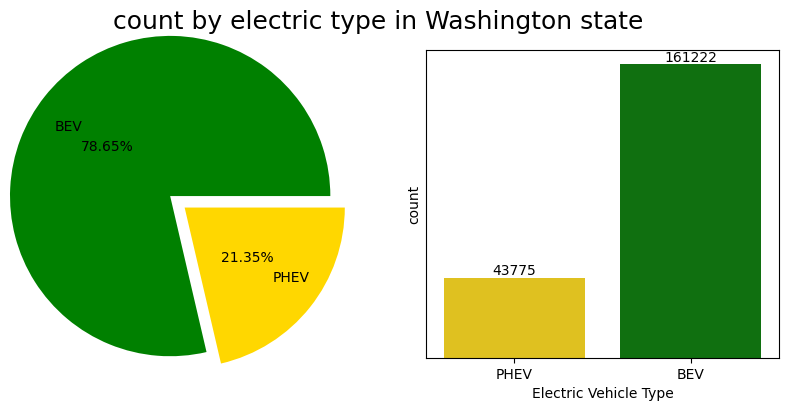

In [36]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
count_elect_type['count'].plot.pie(autopct='%.2f%%', radius=1.3,
                        explode=[0.1, 0.05],colors=elec_type_colors,
                        pctdistance=0.5, labeldistance=0.7)
plt.ylabel('')
plt.subplot(1,2,2)
ax = sns.countplot(df_WA, x='Electric Vehicle Type', palette=['gold', 'green'])
for count in ax.containers:
    ax.bar_label(count)
plt.yticks([])
plt.suptitle('count by electric type in Washington state', fontsize=18)
plt.show()

#### Count by Model Year

In [37]:
table_count_model_year = pd.pivot_table(df_WA, values='VIN (1-10)' , 
                       index=['Model Year'],
                       aggfunc={'count'}, fill_value=0)

table_count_model_year.style.bar(cmap='RdYlGn')

,count
Model Year,
1997,1
1999,4
2000,7
2002,2
2003,1
2008,22
2010,24
2011,707
2012,1546


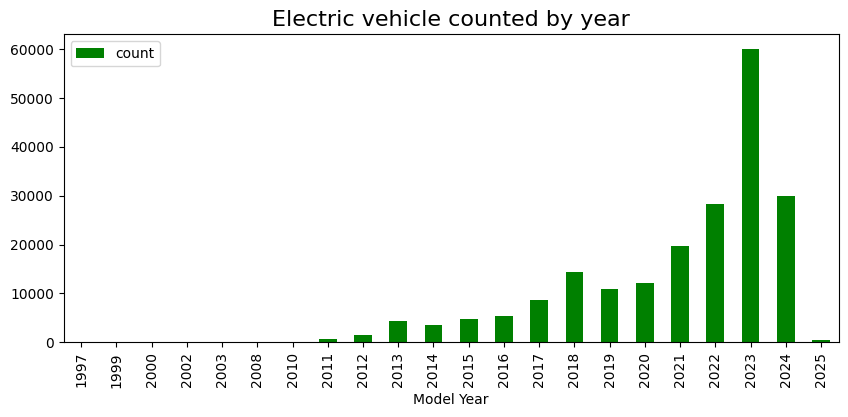

In [38]:
table_count_model_year.plot.bar(color='green', figsize=(10, 4))
plt.title('Electric vehicle counted by year', fontsize=16)
plt.show()

#### Count by Model Year and Electric Type

In [39]:
table_year_type = pd.pivot_table(df_WA, values='VIN (1-10)' , 
                       index=['Model Year'],
                       columns = ['Electric Vehicle Type'],
                       aggfunc={'count'}, fill_value=0)

In [40]:
table_year_type.style.bar(cmap='RdYlGn')

In [41]:
table = pd.pivot_table(df_WA, values='VIN (1-10)' , columns=['Make'],
                       index=['Model Year'], aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_table = table.style.format("{:d}").background_gradient(cmap='YlGnBu', axis=1)#.set_caption('Pivot Table with Conditional Formatting')

# Display the styled pivot table
styled_table

Year 2023 has the largest number of electric cars, both BEV and PHEV.

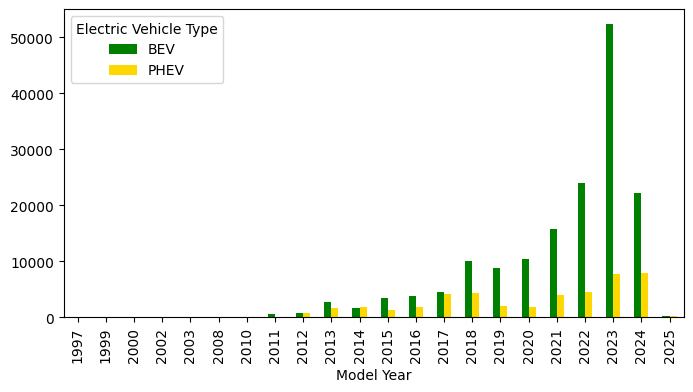

In [42]:
table_year_type['count'].plot.bar(color =elec_type_colors, figsize=(8, 4))
plt.show()

#### Count by Make and Electric Type

In [43]:
table_make_type = pd.pivot_table(df_WA, values='VIN (1-10)' , 
                       index=['Make'], columns = ['Electric Vehicle Type'],
                       aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_table_make_type = table_make_type.style.format("{:d}").bar(axis=0, cmap='Greens')#.set_caption('Pivot Table with Conditional Formatting')

# Display the styled pivot table
styled_table_make_type

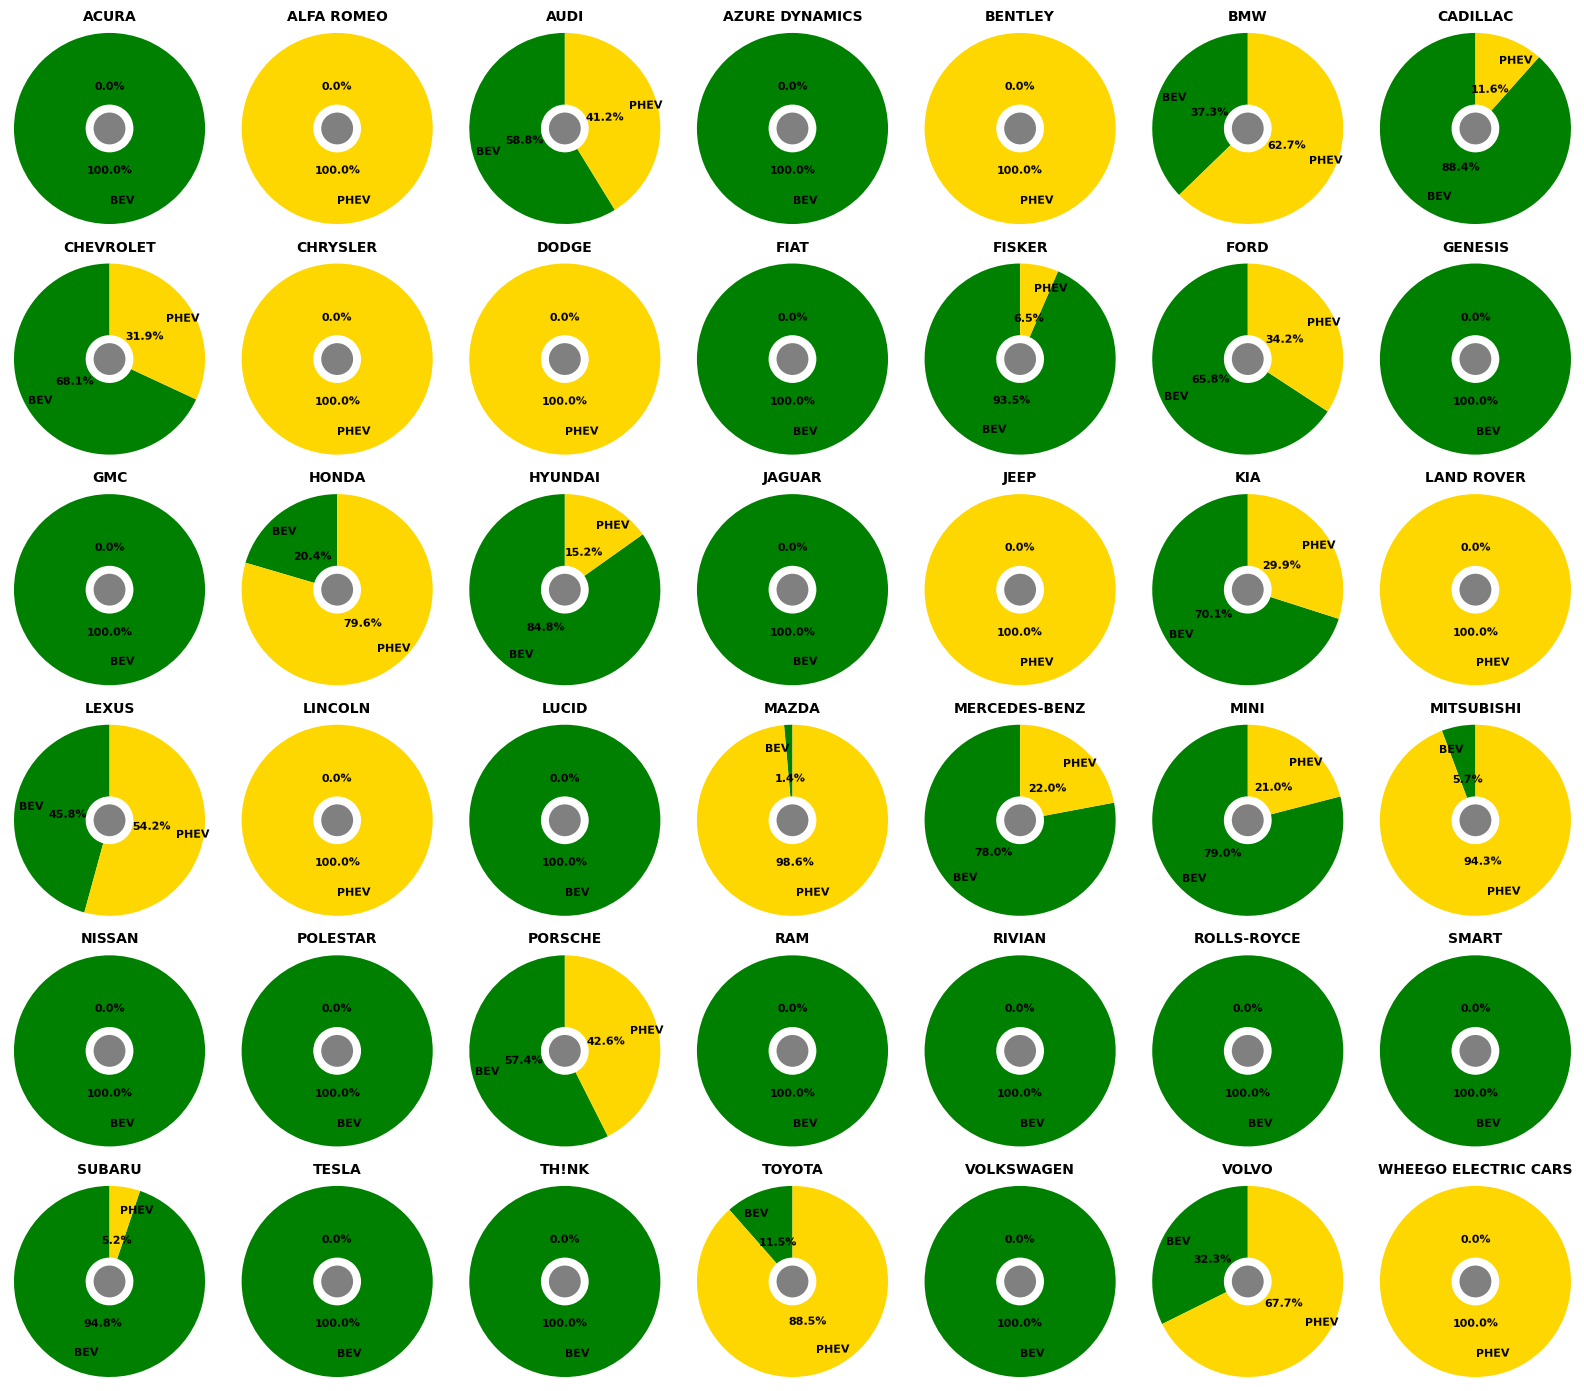

In [44]:
plt.figure(figsize=(16, 14))
for m, Make in enumerate(table_make_type.index, start=1):
    plt.subplot(6, 7, m)
    pd.Series({' ': 1}).plot.pie(colors=['grey'], radius=0.2, shadow=False)
    table_make_type.loc[Make, :]['count'].plot.pie(autopct='%.1f%%', radius=1.2, pctdistance=0.44, shadow=False, 
                                         textprops={'color':'black', 'rotation':True, 'weight':'bold', 'size': 8},
                                         startangle=90, colors=elec_type_colors , rotatelabels=True,
                                         labeldistance=0.7, wedgeprops={'width':0.9}, frame=True)
    plt.ylabel('')
    plt.title(Make, color='black', fontsize=10, weight='bold')
plt.tight_layout()

We will focus on the top ten car makes.

#### Count Within Top 10 Makes

In [45]:
Top_10_Makes = list(df_WA['Make'].value_counts().head(10).index)

df_WA_10 = df_WA.query("Make in ['TESLA','CHEVROLET','NISSAN','FORD','KIA','BMW','TOYOTA','HYUNDAI','RIVIAN','VOLKSWAGEN']")

In [46]:
table = pd.pivot_table(df_WA_10, values='VIN (1-10)' , columns=['Make'],
                       index=['County'], aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_table = table.style.format("{:d}").background_gradient(cmap='YlGn', axis=1)#.set_caption('Pivot Table with Conditional Formatting')

# Display the styled pivot table
styled_table

In [47]:
table = pd.pivot_table(df_WA_10, values='VIN (1-10)' , columns=['Make'],
                       index=['County'], aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_table = table.style.format("{:d}").bar(cmap='YlGn', axis=1)#.set_caption('Pivot Table with Conditional Formatting')

# Display the styled pivot table
styled_table

#### Count Within Counties

In [48]:
table_county_Make = pd.pivot_table(df_WA_10, values='VIN (1-10)' , columns=['Make'],
                       index=['County'], aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_table_county_Make = table_county_Make.style.format("{:d}").background_gradient(cmap='Blues', axis=0).background_gradient(cmap='Greens', axis=0)#.set_caption('Pivot Table with Conditional Formatting')

# Display the styled pivot table
styled_table_county_Make

In [49]:
df_full['Legislative District'].astype('string').map(lambda x: x.split('.')[0]).value_counts().to_frame().style.bar(cmap='RdYlBu')

,count
Legislative District,
41,12994
45,12003
48,11184
1,8946
5,8787
11,8773
36,8297
46,7790
43,7236


In [50]:
table = pd.pivot_table(df_WA_10, values='VIN (1-10)' , columns=['Make'],
                       index=['Legislative District', 'Electric Vehicle Type'], aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_table = table.style.format("{:d}").background_gradient(cmap='YlGn', axis=1)#.set_caption('Pivot Table with Conditional Formatting')

# Display the styled pivot table
styled_table

#### Count within Cities

In [ ]:
table = pd.pivot_table(df_WA_10, values='VIN (1-10)' , columns=['Make'],
                       index=['City'], aggfunc={'count'}, fill_value=0)

# Apply styling to the pivot table
styled_table = table.style.format("{:d}").background_gradient(cmap='YlGn', axis=0)#.set_caption('Pivot Table with Conditional Formatting')

# Display the styled pivot table
styled_table

# 5. Geospatial Analysis in Washington

## 5.1 Map distribution in Washington for Electric Type

In [52]:
gdf_WA_BEV = gdf_WA[gdf_WA['Electric Vehicle Type']=='BEV']
gdf_WA_PHEV = gdf_WA[gdf_WA['Electric Vehicle Type']=='PHEV']

In [ ]:
# Create the map
WA_map = folium.Map(location=[47.46, -120.67], tiles='cartodbpositron', zoom_start=7.8)


def color_scheem(val):
    if val == 'BEV':
        return 'green'
    else:
        return 'yellow'

for i in range(0, len(gdf_WA)):
    folium.Circle(
        location= (gdf_WA.iloc[i]['lat'], gdf_WA.iloc[i]['lon']),
        radius=500,
        color=color_scheem(gdf_WA.iloc[i]['Electric Vehicle Type'])
    ).add_to(WA_map)

# Diplay th map
WA_map

## 5.2 Map distribution BEV Type </span> 

In [ ]:
# Create the map
WA_map = folium.Map(location=[47.25, -120.67], tiles='cartodbpositron', zoom_start=6.8)

# Add points to the map
mc = MarkerCluster()
for idx, row in gdf_WA_BEV.iterrows():
    if not math.isnan(row['lon']) and not math.isnan(row['lat']):
        mc.add_child(Marker([row['lat'], row['lon']]))
WA_map.add_child(mc)

# Display the map
WA_map

## 5.3 Map distribution PHEV Type 

In [ ]:
# Create the map
WA_map = folium.Map(location=[47.25, -120.67], tiles='cartodbpositron', zoom_start=6.8,)

# Add points to the map
mc = MarkerCluster()
for idx, row in gdf_WA_PHEV.iterrows():
    if not math.isnan(row['lon']) and not math.isnan(row['lat']):
        mc.add_child(Marker([row['lat'], row['lon']]))
WA_map.add_child(mc)

# Display the map
WA_map